# **Libraries**

In [1]:
# Import dependencies
from google.colab import files
import os,zipfile,shutil,random,tempfile
%matplotlib inline
from io import BytesIO
from urllib import request
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np ## Images array handle
import tensorflow as tf ## Deep learning library
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator ## Image preprocess and augmentation

# **Data Preparation**

[SoyaBean Dataset from Kaggle](https://www.kaggle.com/datasets/kaustubhachaturvedi/soyabean-disease-dataset)

In [2]:
#upload kaggle api key
! pip install kaggle
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


In [3]:
# Create a helper function to unzip file(s)
def unzip(zipfileNameList):
  for file in zipfileNameList:
    fileZip = str(file) + '.zip'
    try:
      zipRef = zipfile.ZipFile(fileZip, 'r')
    except:
      print("Something went wrong when read to the unzip file")
    zipRef.extractall('./' + file + '/')
    zipRef.close()

def downloadAndUnzipDataset(*datasetLink):
  zipfileName = [] 
  for link in datasetLink:
    slashSplit = str(link).split('/')
    if slashSplit[-3] != 'datasets' and slashSplit[-3] != 'competitions':
      raise Exception('Link(s) format are not as expected')
    if slashSplit[-3] == 'datasets':
      datasetName = slashSplit[-2] + '/' + slashSplit[-1]
      ! kaggle datasets download $datasetName
    if slashSplit[-3] == 'competitions':
      datasetName = slashSplit[-1]
      ! kaggle competitions download -c $datasetName
    zipfileName.append(slashSplit[-1])
  unzip(zipfileName)
  
downloadAndUnzipDataset('https://www.kaggle.com/datasets/kaustubhachaturvedi/soyabean-disease-dataset')

100% 255M/255M [00:10<00:00, 33.7MB/s]
100% 255M/255M [00:10<00:00, 25.8MB/s]


In [4]:
def moveImage(srcDir, classnameList, destinationRootDir):
  if not os.path.exists(destinationRootDir):
    os.makedirs(destinationRootDir)
  subdir = sorted([dirs for root, dirs, files in os.walk(srcDir)][0])[0]
  classSrc = sorted([dirs for root, dirs, files in os.walk(srcDir)][1])
  for index in range(len(classnameList)):
    subdirPath = os.path.join(srcDir, subdir)
    classDir = os.path.join(subdirPath, classSrc[index])
    for file in os.listdir(classDir):
      if not os.path.exists(os.path.join(destinationRootDir, str(classnameList[index]))):
        os.makedirs(os.path.join(destinationRootDir, str(classnameList[index])))
        shutil.copy(os.path.join(classDir, file), 
                    os.path.join(destinationRootDir, str(classnameList[index])))
      else:
        shutil.copy(os.path.join(classDir, file), 
                    os.path.join(destinationRootDir, str(classnameList[index])))

In [5]:
# defining classes of diseases in soyabean plant from soyabean-disease-dataset
soybeanleafClassname = ['Angular Leaf Spot', 
                         'Bacterial Blight',
                         'Bean Rust',
                         'Downy Mildew',
                         'Healthy',]
# removed yellow mosiac disease because low data in dataset is causing overfitting problems
rootDir = '/tmp/Data'

if os.path.exists(rootDir):
  shutil.rmtree(rootDir)

moveImage('./soyabean-disease-dataset/test', soybeanleafClassname, rootDir)
moveImage('./soyabean-disease-dataset/train', soybeanleafClassname, rootDir)
moveImage('./soyabean-disease-dataset/validation', soybeanleafClassname, rootDir)

# **Split Dataset**

In [6]:
#using temperory data folder to split train,test,validation data in directory
def splitClassData(SOURCE, TRAINING, VALIDATION, TESTING, SPLITSIZE):
  for dir in [TRAINING, VALIDATION, TESTING]:
    if not os.path.exists(dir):
      os.makedirs(dir)

  if SPLITSIZE > 1 or SPLITSIZE < 0:
    raise Exception('split size should be between 0 and 1')

  trainValLen = int(len(os.listdir(SOURCE)) * SPLITSIZE)
  for index, file in enumerate(os.listdir(SOURCE)): 
    if index < trainValLen:
      if index < int(.7 * trainValLen): 
        shutil.copy(os.path.join(SOURCE, file), os.path.join(str(TRAINING)))
      else:
        shutil.copy(os.path.join(SOURCE, file), os.path.join(str(VALIDATION)))
    else:
      shutil.copy(os.path.join(SOURCE, file), os.path.join(str(TESTING)))

# Display distribution of images in folder.
def displayDistribution(DIR, splitType=['Train', 'Validation', 'Test']):
  userInputType = [splitType]
  typeList = ['Train', 'Validation', 'Test']
  if len(userInputType) > 1:
    raise Exception("Please choose one type of split")
  if userInputType[0] not in typeList:
    raise Exception("Please choose a type of split that provided; \'Train\', \'Validation\', or \'Test\'")
  
  print("\n{}".format(userInputType[0]))
  for dirClass in sorted(os.listdir(DIR)):
    print('{}: {} images'.format(dirClass, len(os.listdir(os.path.join(DIR, dirClass)))))


In [7]:
# calling split function for each class and setting directory for each class in variable
rootSplitDir = '/tmp/Split'
if os.path.exists(rootSplitDir):
  shutil.rmtree(rootSplitDir)

trainSplitDir = os.path.join(rootSplitDir, 'Train')
validationSplitDir = os.path.join(rootSplitDir, 'Validation')
testSplitDir = os.path.join(rootSplitDir, 'Test')

alsTrainDir = os.path.join(trainSplitDir, soybeanleafClassname[0])
bbTrainDir = os.path.join(trainSplitDir, soybeanleafClassname[1])
brTrainDir = os.path.join(trainSplitDir, soybeanleafClassname[2])
dmTrainDir = os.path.join(trainSplitDir, soybeanleafClassname[3])
healthyTrainDir = os.path.join(trainSplitDir, soybeanleafClassname[4])

alsTestDir = os.path.join(testSplitDir, soybeanleafClassname[0])
bbTestDir = os.path.join(testSplitDir, soybeanleafClassname[1])
brTestDir = os.path.join(testSplitDir, soybeanleafClassname[2])
dmTestDir = os.path.join(testSplitDir, soybeanleafClassname[3])
healthyTestDir = os.path.join(testSplitDir, soybeanleafClassname[4])

alsValidationDir = os.path.join(validationSplitDir, soybeanleafClassname[0])
bbValidationDir = os.path.join(validationSplitDir, soybeanleafClassname[1])
brValidationDir = os.path.join(validationSplitDir, soybeanleafClassname[2])
dmValidationDir = os.path.join(validationSplitDir, soybeanleafClassname[3])
healthyValidationDir = os.path.join(validationSplitDir, soybeanleafClassname[4])

alsSourceDir = os.path.join(rootDir, soybeanleafClassname[0])
bbSourceDir = os.path.join(rootDir, soybeanleafClassname[1])
brSourceDir = os.path.join(rootDir, soybeanleafClassname[2])
dmSourceDir = os.path.join(rootDir, soybeanleafClassname[3])
healthSourceDir = os.path.join(rootDir, soybeanleafClassname[4])

splitSize = .999

splitClassData(alsSourceDir, alsTrainDir, alsValidationDir, alsTestDir, splitSize)
splitClassData(bbSourceDir, bbTrainDir, bbValidationDir, bbTestDir, splitSize)
splitClassData(brSourceDir, brTrainDir, brValidationDir, brTestDir, splitSize)
splitClassData(dmSourceDir, dmTrainDir, dmValidationDir, dmTestDir, splitSize)
splitClassData(healthSourceDir, healthyTrainDir, healthyValidationDir, healthyTestDir, splitSize)

print('[Split Distribution]')
displayDistribution(trainSplitDir, splitType='Train')
displayDistribution(validationSplitDir, splitType='Validation')
displayDistribution(testSplitDir, splitType='Test')

[Split Distribution]

Train
Angular Leaf Spot: 301 images
Bacterial Blight: 164 images
Bean Rust: 304 images
Downy Mildew: 85 images
Healthy: 298 images

Validation
Angular Leaf Spot: 130 images
Bacterial Blight: 71 images
Bean Rust: 131 images
Downy Mildew: 37 images
Healthy: 128 images

Test
Angular Leaf Spot: 1 images
Bacterial Blight: 1 images
Bean Rust: 1 images
Downy Mildew: 1 images
Healthy: 1 images



Label: Angular Leaf Spot


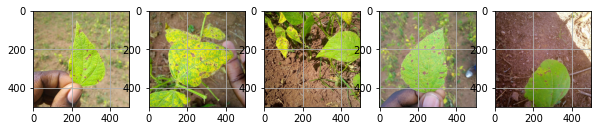


Label: Bacterial Blight


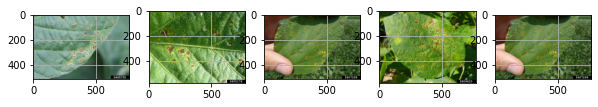


Label: Bean Rust


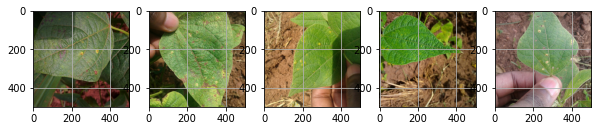


Label: Downy Mildew


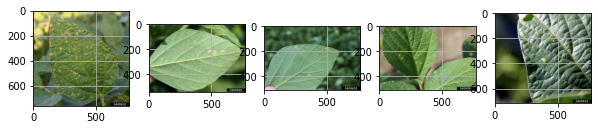


Label: Healthy


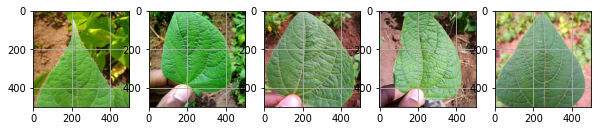

In [38]:
for eachClass in classList:
    classDir = os.path.join(rootDir, eachClass)
    plt.figure(figsize=(50/5, 4))
    print("\nLabel: {}".format(eachClass))
    for index, imagePath in enumerate(os.listdir(classDir)[:5]):
        ax = plt.subplot(1, 5, index+1)
        image = mpimg.imread(os.path.join(classDir, imagePath))
        ax.grid()
        plt.imshow(image)
    plt.show()

# **Data Generator**

Found 1150 images belonging to 5 classes.
Found 497 images belonging to 5 classes.


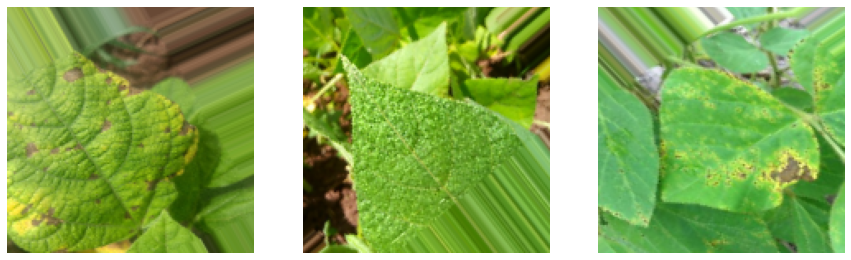

In [98]:
# data generator for basic augmentaion
def trainValGenerator(TRAININGDIR, VALIDATIONDIR, 
                         TARGETSIZE, TRAINBATCHSIZE, VALBATCHSIZE):
  trainDatagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=40,
                                     width_shift_range=.2,
                                     height_shift_range=.2,
                                     shear_range=.2,
                                     zoom_range=.3,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

  trainGenerator = trainDatagen.flow_from_directory(directory=TRAININGDIR,
                                                      batch_size=TRAINBATCHSIZE,
                                                      class_mode='categorical',
                                                      target_size=TARGETSIZE)

  validationDatagen = ImageDataGenerator(rescale=1./255)

  validationGenerator = validationDatagen.flow_from_directory(directory=VALIDATIONDIR,
                                                                batch_size=VALBATCHSIZE,
                                                                class_mode='categorical',
                                                                target_size=TARGETSIZE)
  return trainGenerator, validationGenerator

trainBatchSize = 32
valBatchSize = 32
targetSize = (150, 150)

trainGenerator, validationGenerator = trainValGenerator(trainSplitDir,
                                                            validationSplitDir,
                                                            targetSize,
                                                            trainBatchSize,
                                                            valBatchSize)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,15))
for i in range(3):
  image = trainGenerator[i+2][0][0]
  ax[i].imshow(image)
  ax[i].axis('off')

# **Model v1.0 CNN**

## **Model Architecture**

In [10]:
# Create a simple CNN architecture
def createModel(TARGETSIZE):
  model = tf.keras.models.Sequential([ 
      ### The first convolution and maxpool                                  
      tf.keras.layers.Conv2D(32, (3,3), activation='relu',
                             input_shape=(TARGETSIZE[0], TARGETSIZE[1], 3)),
      tf.keras.layers.MaxPooling2D(2,2),
      ### The second convolution and maxpool                                  
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      ### The third convolution and maxpool                                  
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      ### The fourth convolution and maxpool                                  
      tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      ### Flatten convolution part result
      tf.keras.layers.Flatten(),
      ### The first dense layer
      tf.keras.layers.Dense(1024, activation='relu'),
      ### The second dense layer
      tf.keras.layers.Dense(512, activation='relu'),
      ### The output layer
      tf.keras.layers.Dense(5, activation='softmax', name="predict_class")
  ])

  ## Compile model with its optimizer, loss, and metrics  
  model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss='categorical_crossentropy',
                metrics=['accuracy']) 

  ## Return the created model  
  return model
modelV1 = createModel(targetSize)

## **Training the Model**

In [11]:
# Custom Callbacks Funtion
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') > .98 and logs.get('val_accuracy') > .98:
      # Stop if 98% accuracy is reached
      print("\nThe thresholds are met so stop training!")
      self.model.stop_training = True


callbacks = myCallback()
# Instruction to stop early
earlyStop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=8)
# Model checkpoint
modelCp = tf.keras.callbacks.ModelCheckpoint('modelV1.h5', monitor='val_accuracy',
                                                  mode='max', verbose=1, save_best_only=True)

In [12]:
# Training the model
history = modelV1.fit(trainGenerator,
                         epochs=50,
                         steps_per_epoch=int(trainGenerator.samples/trainBatchSize),
                         verbose=1,
                         validation_data=validationGenerator,
                         validation_steps=int(validationGenerator.samples/valBatchSize),
                         callbacks=[callbacks, earlyStop, modelCp])
#get score of model trained
trainScore = modelV1.evaluate(trainGenerator)
validationScore = modelV1.evaluate(validationGenerator)

Epoch 1/50
35/35 [==============================] - ETA: 0s - loss: 1.5191 - accuracy: 0.2818
Epoch 1: val_accuracy improved from -inf to 0.34167, saving model to modelV1.h5
35/35 [==============================] - 28s 461ms/step - loss: 1.5191 - accuracy: 0.2818 - val_loss: 1.4490 - val_accuracy: 0.3417
Epoch 2/50
35/35 [==============================] - ETA: 0s - loss: 1.2686 - accuracy: 0.4553
Epoch 2: val_accuracy improved from 0.34167 to 0.52917, saving model to modelV1.h5
35/35 [==============================] - 15s 441ms/step - loss: 1.2686 - accuracy: 0.4553 - val_loss: 1.1033 - val_accuracy: 0.5292
Epoch 3/50
35/35 [==============================] - ETA: 0s - loss: 1.0967 - accuracy: 0.5331
Epoch 3: val_accuracy improved from 0.52917 to 0.58958, saving model to modelV1.h5
35/35 [==============================] - 15s 438ms/step - loss: 1.0967 - accuracy: 0.5331 - val_loss: 0.9706 - val_accuracy: 0.5896
Epoch 4/50
35/35 [==============================] - ETA: 0s - loss: 0.9792 -

## **Result Plot & Model Score Evaluation**

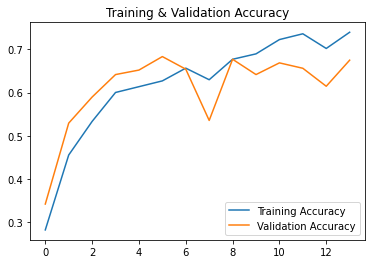

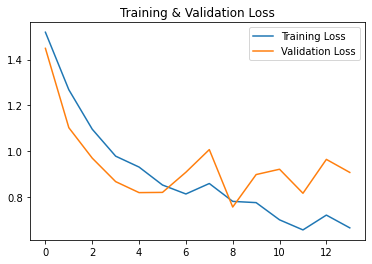

Overall Train Accuracy : 75.30%
Overall Validation Accuracy: 68.01%


In [13]:
# Plot the train result
## Get accuracies histories

acc = history.history['accuracy']
valAcc = history.history['val_accuracy']

## Get losses histories
loss = history.history['loss']
valLoss = history.history['val_loss']

epochs = range(len(acc))

## Plot accuracies result
plt.plot(epochs, acc, label = 'Training Accuracy')
plt.plot(epochs, valAcc, label = 'Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.show() 
plt.figure()

## Plot losses result
plt.plot(epochs, loss, label ='Training Loss')
plt.plot(epochs, valLoss, label = 'Validation Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()  
# print model training and validation score in percent
print('Overall Train Accuracy : {0:.2f}%'.format(trainScore[1]*100))
print('Overall Validation Accuracy: {0:.2f}%'.format(validationScore[1]*100))

## **Predict Image**

1/1 [==============================] - 0s 16ms/step
Actual class: Angular Leaf Spot
Predicted class: Angular Leaf Spot
 with the probabilities for each class as follow 
[8.8329208e-01 4.8990369e-05 1.0481323e-01 3.4507952e-06 1.1842252e-02]


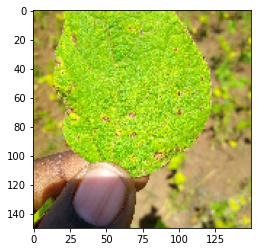

In [34]:
# Function to select random class and random image from that class from test dataset
classList = sorted([dirs for root, dirs, files in os.walk(testSplitDir)][0])
randomClass = os.path.join(testSplitDir, random.choice(classList))
randomImage = random.choice(os.listdir(randomClass))
selectedImage = load_img(os.path.join(randomClass, randomImage), target_size=targetSize)
# enter url and uncomment 2 lines below to use internet image for testing instead

# res=request.urlopen('https://soybeanresearchinfo.com/wp-content/uploads/2019/03/Downy-Mildew-D.-Mueller-15-1300x975.jpg').read()
# selectedImage = load_img(BytesIO(res),target_size=targetSize)

# Predict the image
x = img_to_array(selectedImage)
x = np.expand_dims(x, axis=0)
x = np.vstack([x])
x /= 255.
classes = modelV1.predict(x)
predictedClass = np.argmax(classes)

# Display the image and its predicted class
imageplot = plt.imshow(selectedImage)
#actual classes is for predicting random image is dosent represent iternet image if that is used
print("Actual class: {}".format(randomClass.split('/')[-1]))
print("Predicted class: {}\n with the probabilities for each class as follow \n{}".format(classList[predictedClass], classes[0]))

# **Generator with Data Augmentation**

In [15]:
#pixel level eraser function to provide better contrast in data
def getRandomEraser(p=0.5, sL=0.02, sH=0.4, r_1=0.3, r_2=1/0.3, vL=0, vH=255, pixelLevel=False):
    def eraser(inputImg):
        if inputImg.ndim == 3:
            imgH, imgW, imgC = inputImg.shape
        elif inputImg.ndim == 2:
            imgH, imgW = inputImg.shape

        p_1 = np.random.rand()

        if p_1 > p:
            return inputImg
        while True:
            s = np.random.uniform(sL, sH) * imgH * imgW
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, imgW)
            top = np.random.randint(0, imgH)

            if left + w <= imgW and top + h <= imgH:
                break
        if pixelLevel:
            if inputImg.ndim == 3:
                c = np.random.uniform(vL, vH, (h, w, imgC))
            if inputImg.ndim == 2:
                c = np.random.uniform(vL, vH, (h, w))
        else:
            c = np.random.uniform(vL, vH)

        inputImg[top:top + h, left:left + w] = c
        return inputImg
    return eraser

Found 1150 images belonging to 5 classes.
Found 497 images belonging to 5 classes.


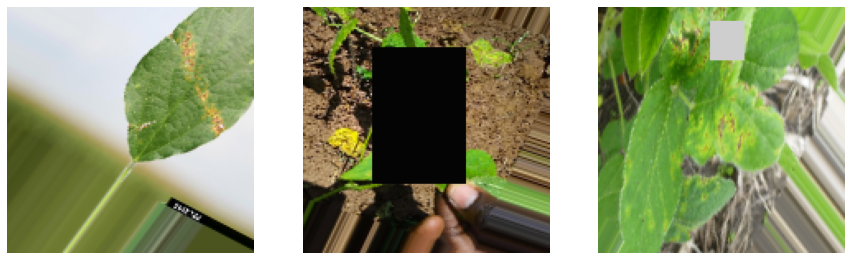

In [99]:
# data generator for augmentation with eraser function 
def trainValGenerator(TRAININGDIR, VALIDATIONDIR, 
                         TARGETSIZE, TRAINBATCHSIZE, VALBATCHSIZE):
  trainDatagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=40,
                                     width_shift_range=.2,
                                     height_shift_range=.2,
                                     shear_range=.2,
                                     zoom_range=.3,
                                     horizontal_flip=True,
                                     preprocessing_function=getRandomEraser(), 
                                     fill_mode='nearest')

  trainGenerator = trainDatagen.flow_from_directory(directory=TRAININGDIR,
                                                      batch_size=TRAINBATCHSIZE,
                                                      class_mode='categorical',
                                                      target_size=TARGETSIZE)

  validationDatagen = ImageDataGenerator(rescale=1./255)

  validationGenerator = validationDatagen.flow_from_directory(directory=VALIDATIONDIR,
                                                                batch_size=VALBATCHSIZE,
                                                                class_mode='categorical',
                                                                target_size=TARGETSIZE)
  
  return trainGenerator, validationGenerator

trainBatchSize = 32
valBatchSize = 32
targetSize = (150, 150)

trainGenerator, validationGenerator = trainValGenerator(trainSplitDir,
                                                            validationSplitDir,
                                                            targetSize,
                                                            trainBatchSize,
                                                            valBatchSize)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,15))
for i in range(3):
  image = trainGenerator[i+2][0][0]
  ax[i].imshow(image)
  ax[i].axis('off')


# **Model v1.1 CNN with Data Augmentation**

## **Model Architecture**

In [17]:
# Create a simple CNN architecture
def createModel(TARGETSIZE):
  model = tf.keras.models.Sequential([ 
      ### The first convolution and maxpool                                  
      tf.keras.layers.Conv2D(32, (3,3), activation='relu',
                             input_shape=(TARGETSIZE[0], TARGETSIZE[1], 3)),
      tf.keras.layers.MaxPooling2D(2,2),
      ### The second convolution and maxpool                                  
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      ### The third convolution and maxpool                                  
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      ### The fourth convolution and maxpool                                  
      tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      ### Flatten convolution part result
      tf.keras.layers.Flatten(),
      ### The first dense layer
      tf.keras.layers.Dense(1024, activation='relu'),
      ### The second dense layer
      tf.keras.layers.Dense(512, activation='relu'),
      ### The output layer
      tf.keras.layers.Dense(5, activation='softmax', name="predict_class")
  ])

  ## Compile model with its optimizer, loss, and metrics  
  model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss='categorical_crossentropy',
                metrics=['accuracy']) 

  ## Return the created model  
  return model
modelV1Agu = createModel(targetSize)

## **Training the Model**

In [18]:
# Custom Callbacks Funtion
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') > .98 and logs.get('val_accuracy') > .98:
      # Stop if 98% accuracy is reached
      print("\nThe thresholds are met so stop training!")
      self.model.stop_training = True


callbacks = myCallback()
# Instruction to stop early
earlyStop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=8)
# Model checkpoint
modelCp = tf.keras.callbacks.ModelCheckpoint('modelV1Agu.h5', monitor='val_accuracy',
                                                  mode='max', verbose=1, save_best_only=True)

In [19]:
# Train the model
history = modelV1Agu.fit(trainGenerator,
                         epochs=50,
                         steps_per_epoch=int(trainGenerator.samples/trainBatchSize),
                         verbose=1,
                         validation_data=validationGenerator,
                         validation_steps=int(validationGenerator.samples/valBatchSize),
                         callbacks=[callbacks, earlyStop, modelCp])
#get score of model trained
trainScore = modelV1Agu.evaluate(trainGenerator)
validationScore = modelV1Agu.evaluate(validationGenerator)

Epoch 1/50
35/35 [==============================] - ETA: 0s - loss: 1.3961 - accuracy: 0.3732
Epoch 1: val_accuracy improved from -inf to 0.50417, saving model to modelV1Agu.h5
35/35 [==============================] - 16s 455ms/step - loss: 1.3961 - accuracy: 0.3732 - val_loss: 1.1732 - val_accuracy: 0.5042
Epoch 2/50
35/35 [==============================] - ETA: 0s - loss: 1.1994 - accuracy: 0.4893
Epoch 2: val_accuracy did not improve from 0.50417
35/35 [==============================] - 16s 470ms/step - loss: 1.1994 - accuracy: 0.4893 - val_loss: 1.2752 - val_accuracy: 0.4271
Epoch 3/50
35/35 [==============================] - ETA: 0s - loss: 1.0920 - accuracy: 0.5555
Epoch 3: val_accuracy did not improve from 0.50417
35/35 [==============================] - 15s 429ms/step - loss: 1.0920 - accuracy: 0.5555 - val_loss: 1.1691 - val_accuracy: 0.4938
Epoch 4/50
35/35 [==============================] - ETA: 0s - loss: 1.0730 - accuracy: 0.5626
Epoch 4: val_accuracy did not improve from 

## **Result Plot & Model Score Evaluation**

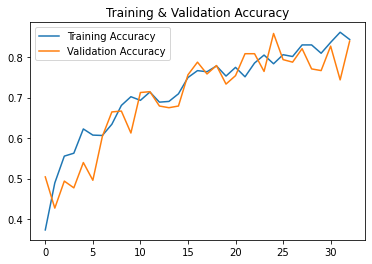

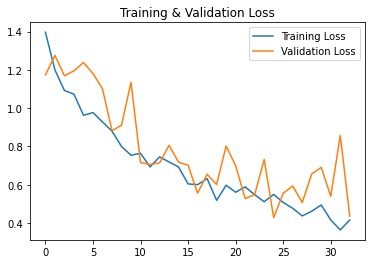

Overall Train Accuracy : 83.30%
Overall Validation Accuracy: 83.90%


In [20]:
# Plot the train result
## Get accuracies histories

acc = history.history['accuracy']
valAcc = history.history['val_accuracy']

## Get losses histories
loss = history.history['loss']
valLoss = history.history['val_loss']

epochs = range(len(acc))

## Plot accuracies result
plt.plot(epochs, acc, label = 'Training Accuracy')
plt.plot(epochs, valAcc, label = 'Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.show() 
plt.figure()

## Plot losses result
plt.plot(epochs, loss, label ='Training Loss')
plt.plot(epochs, valLoss, label = 'Validation Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()  
# print model training and validation score in percent
print('Overall Train Accuracy : {0:.2f}%'.format(trainScore[1]*100))
print('Overall Validation Accuracy: {0:.2f}%'.format(validationScore[1]*100))

## **Predict Image**

1/1 [==============================] - 0s 15ms/step
Actual class: Healthy
Predicted class: Healthy
 with the probabilities for each class as follow 
[1.3774951e-03 4.8914557e-05 1.0436818e-02 3.4069146e-03 9.8472983e-01]


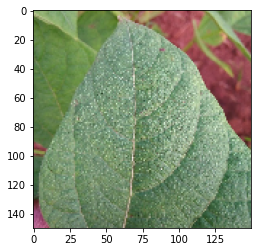

In [33]:
# Function to select random class and random image from that class from test dataset
classList = sorted([dirs for root, dirs, files in os.walk(testSplitDir)][0])
randomClass = os.path.join(testSplitDir, random.choice(classList))
randomImage = random.choice(os.listdir(randomClass))
selectedImage = load_img(os.path.join(randomClass, randomImage), target_size=targetSize)
# enter url and uncomment 2 lines below to use internet image for testing instead

# res=request.urlopen('https://soybeanresearchinfo.com/wp-content/uploads/2019/03/Downy-Mildew-D.-Mueller-15-1300x975.jpg').read()
# selectedImage = load_img(BytesIO(res),target_size=targetSize)

# Predict the image
x = img_to_array(selectedImage)
x = np.expand_dims(x, axis=0)
x = np.vstack([x])
x /= 255.
classes = modelV1Agu.predict(x)
predictedClass = np.argmax(classes)

# Display the image and its predicted class
imageplot = plt.imshow(selectedImage)
#actual classes is for predicting random image is dosent represent iternet image if that is used
print("Actual class: {}".format(randomClass.split('/')[-1]))
print("Predicted class: {}\n with the probabilities for each class as follow \n{}".format(classList[predictedClass], classes[0]))

# **Model v1.2 - ResNetV2 Fine Tuned**

## **Model Architecture**

In [22]:
# Using ResnetV2 model to classify images with better accuracy
def useResnetModel(WEIGHTS, TARGETSIZE):

  ## Import ResnetV2 Model
  ResnetModel = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
      input_shape = (TARGETSIZE[0], TARGETSIZE[1], 3),
      include_top = False, 
      weights = WEIGHTS)
  
  return ResnetModel
ResnetModel = useResnetModel('imagenet', targetSize)

219055592/219055592 [==============================] - 7s 0us/step


In [23]:
# Create a function to pipeline imported model
## Set the desired layer from pre-trained model as a input for self-model
def outputOfLastLayer(ResnetModel):
  lastDesiredLayer = ResnetModel.get_layer('mixed_7a')
  lastOutput = lastDesiredLayer.output

  return lastOutput
# Execute the prior function
lastOutput = outputOfLastLayer(ResnetModel)

In [24]:
# Create Final Model with fine tuning using last layer and ResnetModel
def createModel(ResnetModel, LASTOUTPUT):
  # Flatten the output layer to 1 dimension
  x = tf.keras.layers.Flatten()(LASTOUTPUT)
  # Add a fully connected layer with hidden units and ReLU activation
  x = tf.keras.layers.Dense(512, activation='relu')(x)
  # Add dropout rate
  x = tf.keras.layers.Dropout(.8)(x)
  # Add a output layer for classification
  x = tf.keras.layers.Dense(5, activation='softmax', name="predict_class")(x) 

  # Create the complete model by using the Model class
  model = tf.keras.Model(inputs=ResnetModel.input, outputs=x)

  # Fine Tuning
  NUMLAYERS = 9
  doFineTuning = True

  if doFineTuning:
      optimizer = tf.keras.optimizers.SGD(learning_rate=5e-3, momentum=0.9)
      for layer in model.layers[-NUMLAYERS:]:
          layer.trainable = True

      # Make all the layers in the ResnetModel model trainable
      for layer in ResnetModel.layers:
          layer.trainable = True
  else:
      optimizer = 'adam'

      # Make all the layers in the ResnetModel model non-trainable
      for layer in ResnetModel.layers:
          layer.trainable = False

  model.compile(loss=tf.keras.losses.CategoricalHinge(),
                optimizer=optimizer,
                metrics=['accuracy'])
  
  return model
# Get the model architecture by pass targetSize defined before
modelV2Agu = createModel(ResnetModel, lastOutput)

## **Training the Model**

In [25]:
# Callbacks schedule
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') > .98 and logs.get('val_accuracy') > .98:
      # Stops if 98% accuracy is achived.
      print("\nThe thresholds are met so stop training!")
      self.model.stop_training = True

callbacks = myCallback()
# Model checkpoint
modelCp = tf.keras.callbacks.ModelCheckpoint('modelV2Agu.h5', monitor='val_accuracy',
                                                  mode='max', verbose=1, save_best_only=True)

In [26]:
# Train the model
history = modelV2Agu.fit(trainGenerator,
                        epochs=50,
                        steps_per_epoch=int(trainGenerator.samples/trainBatchSize),
                        verbose=1,
                        validation_data=validationGenerator,
                        validation_steps=int(validationGenerator.samples/valBatchSize),
                        callbacks=[callbacks, modelCp])

trainScore = modelV2Agu.evaluate(trainGenerator)
validationScore = modelV2Agu.evaluate(validationGenerator)

Epoch 1/50
35/35 [==============================] - ETA: 0s - loss: 1.0351 - accuracy: 0.2585
Epoch 1: val_accuracy improved from -inf to 0.43750, saving model to modelV2Agu.h5
35/35 [==============================] - 38s 680ms/step - loss: 1.0351 - accuracy: 0.2585 - val_loss: 1.0036 - val_accuracy: 0.4375
Epoch 2/50
35/35 [==============================] - ETA: 0s - loss: 1.0180 - accuracy: 0.3193
Epoch 2: val_accuracy improved from 0.43750 to 0.47292, saving model to modelV2Agu.h5
35/35 [==============================] - 21s 598ms/step - loss: 1.0180 - accuracy: 0.3193 - val_loss: 0.9993 - val_accuracy: 0.4729
Epoch 3/50
35/35 [==============================] - ETA: 0s - loss: 1.0130 - accuracy: 0.3658
Epoch 3: val_accuracy improved from 0.47292 to 0.55833, saving model to modelV2Agu.h5
35/35 [==============================] - 20s 558ms/step - loss: 1.0130 - accuracy: 0.3658 - val_loss: 0.9950 - val_accuracy: 0.5583
Epoch 4/50
35/35 [==============================] - ETA: 0s - loss:

## **Result Plot & Model Score Evaluation**

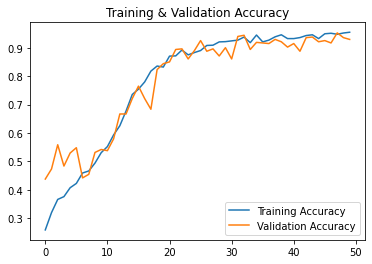

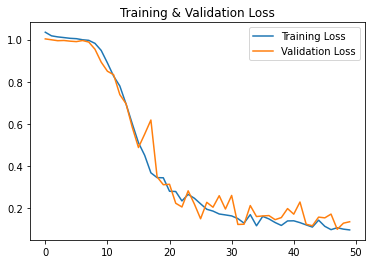

Overall Train Accuracy : 96.52%
Overall Validation Accuracy: 93.16%


In [27]:
# Plot the train result
## Get accuracies histories

acc = history.history['accuracy']
valAcc = history.history['val_accuracy']

## Get losses histories
loss = history.history['loss']
valLoss = history.history['val_loss']

epochs = range(len(acc))

## Plot accuracies result
plt.plot(epochs, acc, label = 'Training Accuracy')
plt.plot(epochs, valAcc, label = 'Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.show() 
plt.figure()

## Plot losses result
plt.plot(epochs, loss, label ='Training Loss')
plt.plot(epochs, valLoss, label = 'Validation Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()  
# print model training and validation score in percent
print('Overall Train Accuracy : {0:.2f}%'.format(trainScore[1]*100))
print('Overall Validation Accuracy: {0:.2f}%'.format(validationScore[1]*100))

## **Predict Image**

1/1 [==============================] - 3s 3s/step
Actual class: Bacterial Blight
Predicted class: Bacterial Blight
 with the probabilities for each class as follow 
[2.8410005e-09 1.0000000e+00 4.0987437e-08 7.0084867e-09 4.7246829e-09]


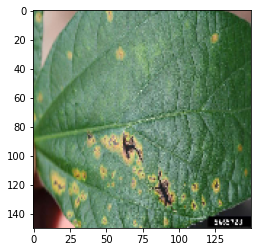

In [28]:
# Function to select random class and random image from that class from test dataset
classList = sorted([dirs for root, dirs, files in os.walk(testSplitDir)][0])
randomClass = os.path.join(testSplitDir, random.choice(classList))
randomImage = random.choice(os.listdir(randomClass))
selectedImage = load_img(os.path.join(randomClass, randomImage), target_size=targetSize)
# enter url and uncomment 2 lines below to use internet image for testing instead

# res=request.urlopen('https://soybeanresearchinfo.com/wp-content/uploads/2019/03/Downy-Mildew-D.-Mueller-15-1300x975.jpg').read()
# selectedImage = load_img(BytesIO(res),target_size=targetSize)

# Predict the image
x = img_to_array(selectedImage)
x = np.expand_dims(x, axis=0)
x = np.vstack([x])
x /= 255.
classes = modelV2Agu.predict(x)
predictedClass = np.argmax(classes)

# Display the image and its predicted class
imageplot = plt.imshow(selectedImage)
#actual classes is for predicting random image is dosent represent iternet image if that is used
print("Actual class: {}".format(randomClass.split('/')[-1]))
print("Predicted class: {}\n with the probabilities for each class as follow \n{}".format(classList[predictedClass], classes[0]))